# Student Name: Murali Krishnan Rajasekharan Pillai
# ECE 595 Machine Learning II
# Project 4: Adversarial Machine Learning

In [1]:
#Install Cleverhans (version Cleverhans 2.1.0 is most compatable with Python 2.x)
!pip install cleverhans==2.1.0

     |████████████████████████████████| 81kB 2.7MB/s 
     |████████████████████████████████| 51kB 8.0MB/s 
     |████████████████████████████████| 163kB 8.7MB/s 


In [2]:
#Import necessary packages
import pickle
import tensorflow as tf
import numpy as np
import keras
from keras import Sequential, backend
from keras.datasets import mnist
from keras.models import load_model, model_from_json
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPool2D, BatchNormalization
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from cleverhans.utils_keras import KerasModelWrapper
from cleverhans.attacks import FastGradientMethod, MadryEtAl, DeepFool, CarliniWagnerL2

Using TensorFlow backend.


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
MODEL_LOCATION = './gdrive/My Drive/ece595_ml2/models/'

# Part 1: Training a target classifier

In [5]:
# Load data MNIST data and normalize to [0, 1]
(data_train, labels_train), (data_test, labels_test) = mnist.load_data()
data_train = data_train / 255.
data_test = data_test / 255.

11493376/11490434 [==============================] - 2s 0us/step


In [0]:
#Reshape training and testing data into 784-dimensional vectors 
data_train = data_train.reshape(-1, 784)
data_test = data_test.reshape(-1, 784)

In [0]:
#Convert integer labels for training and testing data into one-hot vectors 
labels_train = keras.utils.np_utils.to_categorical(labels_train, num_classes=10)
labels_test = keras.utils.np_utils.to_categorical(labels_test, num_classes=10)

In [0]:
#Create classifier architecture, compile it, and train it
class model_methods(object):
  def __init__(self, loss_fn, optim, ndim):
    """
    Try to develop a class which contains common functionality of
    NN models. Like saving a model and it's weights
    """
    self.loss_fn = loss_fn
    self.optim = optim
    self.ndim = ndim

  def save_model_weights(self, h5_file_name):
    """
    Save weights of the model in .h5 format
    Parameters:
      :h5_file_name:    Identifier of the model weights h5 file
    """
    self.model.save_weights(h5_file_name)

  def save_model(self, json_file_name):
    """
    Save the file in a .json file
    Parameters:
      :json_file_name:   Identifier of the model in json file
    """
    model_json = self.model.to_json()
    with open(json_file_name, 'w') as json_file:
      json_file.write(model_json)

  def load_model(self, json_file_name, h5_file_name):
    json_file = open(MODEL_LOCATION + json_file_name, 'r')
    loaded_from_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_from_json)
    model.load_weights(MODEL_LOCATION + h5_file_name)
    return model
    
  def save_model_history(self, model_history, file_name):
    """
    Save model history as a pickle file
    """
    with open(file_name, 'wb') as f:
      pickle.dump(model_history, f)
    
  def load_model_history(self, pkl_file_name):
    """
    Load model history pickle file
    """
    with open(MODEL_LOCATION + pkl_file_name, 'rb') as f:
      model_history = pickle.load(f)
    return model_history

In [0]:
class CNN(model_methods):
  def __init__(self, loss_fn, optim, ndim, num_classes):
    super().__init__(loss_fn, optim, ndim)
    self.num_classes = num_classes
    self.model = self._build_model()

  def _build_model(self):
    """
    Defines and compiles the architecture
    Parameters:
      :loss_fn:      The loss function used in the model
      :optim:        The optimizer used for the model
    Returns:
      :model:        The compiled model
    """
    model = Sequential()
    model.add(Dense(self.ndim*self.ndim,
                    activation='relu',
                    kernel_initializer='normal'))
    model.add(BatchNormalization())
    model.add(Dense(100,
                    activation='relu',
                    kernel_initializer='normal'))
    model.add(BatchNormalization())
    model.add(Dense(self.num_classes,
                    activation='softmax'))
    model.compile(loss=self.loss_fn,
                  optimizer=self.optim,
                  metrics=['accuracy'])
    return model

  def fit(self, d_train, d_test,
          n_epochs=100, batch_size=50, display=25):
    """
    Fit the model
    Parameters:
      :d_train:    Tuple of (training data, training labels)
      :d_test:     Tuple of (testing data, testing labels)
      :n_epochs:   Number of epochs for fit
      :batch_size: Number of samples per gradient update
    Returns:
      :model_hist: History object containing all model history info
    """
    data_train, labels_train = d_train
    model_hist = self.model.fit(data_train, labels_train,
                                validation_data=d_test,
                                epochs=n_epochs,
                                batch_size=batch_size,
                                shuffle=True)
    return model_hist

In [0]:
cnn = CNN('categorical_crossentropy', 'adam', 28, 10)

In [0]:
cnn_hist = cnn.fit((data_train, labels_train),
                    (data_test, labels_test),
                    n_epochs=50,
                    batch_size=256)






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 60000 samples, validate on 10000 samples
Epoch 1/50





60000/60000 [==============================] - 7s 119us/step - loss: 0.1955 - acc: 0.9426 - val_loss: 0.1049 - val_acc: 0.9679
Epoch 2/50
60000/60000 [==============================] - 2s 34us/step - loss: 0.0628 - acc: 0.9819 - val_loss: 0.0729 - val_acc: 0.9761
Epoch 3/50
60000/60000 [==============================] - 2s 35us/step - loss: 0.0347 - acc: 0.9903 - val_loss: 0.0790 - val_acc: 0.9761
Epoch 4/50
60000/60000 [==============================] - 2s 34us/step - loss: 0.0247 - acc: 0.9929 - val_loss: 0.0863 - val_acc: 0.9739
Epoch 5/50
60000/60000 [==============================] - 2s 35us/step - loss: 0.0166 - acc: 0.9952 - val_loss: 0.0629 - val_acc: 0.9808
Epoch 6/50
60000/60000 [==============================] - 2s 34us/step - loss: 0.0107 - acc: 0.9975 - val_loss: 0.0700 - val_acc: 0.9800
Epoch 7/50
60000/600

In [0]:
cnn.save_model_weights("p4_model_weights.h5")
cnn.save_model("p4_model.json")
cnn.save_model_history(cnn_hist, "p4_model_history.pkl")
cnn.model.save("p4_full_model.h5")

In [0]:
! cp -r p4_full_model.h5 p4_model.json p4_model_weights.h5 p4_model_history.pkl ./gdrive/My\ Drive/ece595_ml2/models/

In [0]:
cnn_model = cnn.load_model("p4_model.json", "p4_model_weights.h5")

In [0]:
cnn_reconstructions = cnn_model.predict(data_test)

In [0]:
def plot(hist, param):
  plt.plot(hist.history[param])
  plt.plot(hist.history['val_' + param])
  plt.legend([param, 'val-' + param], loc='upper right')
  plt.xlabel("epochs")
  if param == 'acc':
    plt.ylabel(r"Accuracy (%)")
  elif param == 'loss':
    plt.ylabel(r"Loss")
  plt.tight_layout()
  plt.show()

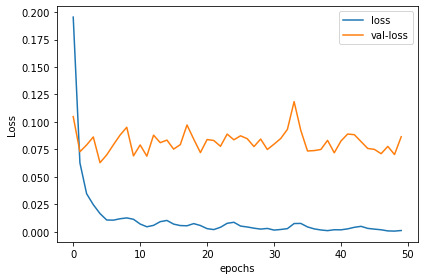

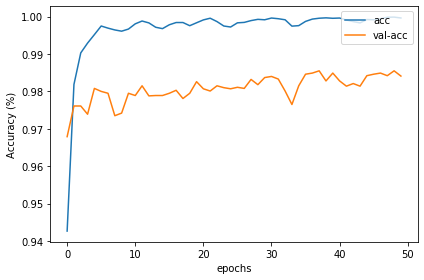

In [0]:
plot(cnn_hist, 'loss')
plot(cnn_hist, 'acc')

In [0]:
scores = cnn.model.evaluate(data_test, labels_test)
print("Accuracy: %.2f%%"%(scores[1]*100))

10000/10000 [==============================] - 1s 63us/step
Accuracy: 98.41%


In [8]:
# Import pre-trained classifier
#mnist_classifier = cnn.load_model("p4_model.json", "p4_model_weights.h5")
mnist_classifier = load_model(MODEL_LOCATION + "p4_full_model.h5")














Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [0]:
#Get TensorFlow Session to pass into Cleverhans modules
sess = backend.get_session()

In [0]:
#Create wrapper for classifier model so that it can be passed into Cleverhans modules
wrap = KerasModelWrapper(mnist_classifier)

# Part 2: The Fast Gradient Method (FGM)

In [0]:
#Implementing the FGSM attack

#FGM Instance on trained classifier from Part 1
fgm = FastGradientMethod(wrap, sess=sess)

In [0]:
#Attack parameters
fgm_params = {'eps': 0.25,
              'clip_min': 0.,
              'clip_max': 1.}

In [36]:
#Generate adversarial data
fgm_attack_data = fgm.generate_np(data_test, **fgm_params)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [38]:
#Evaluate accuracy on target classifier 
fgm_adv_scores = mnist_classifier.evaluate(fgm_attack_data, labels_test)
print("Accuracy: %.2f%%"%(fgm_adv_scores[1]*100))

10000/10000 [==============================] - 1s 82us/step
Accuracy: 11.81%


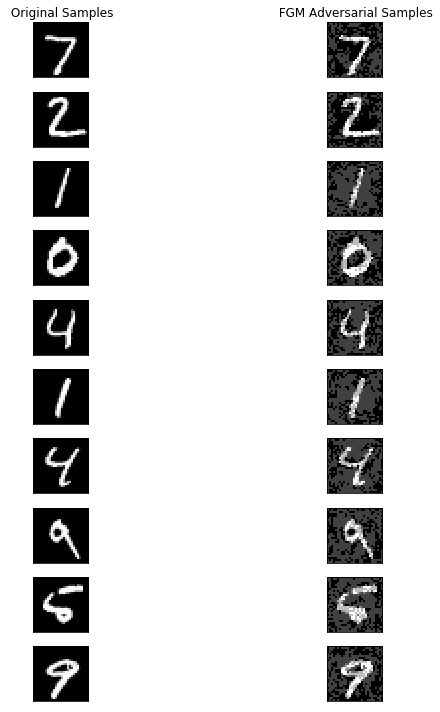

In [39]:
#Show ten original samples and their corresponding adversarial samples
data_test_show = data_test.reshape(-1, 28, 28)
fgm_attack_data_show = fgm_attack_data.reshape(-1, 28, 28)
cols = [' Original Samples',
         ' FGM Adversarial Samples']
fig, axes = plt.subplots(nrows=10, ncols=2, figsize=(10, 10))
for i in range(10):
  axes[i, 0].imshow(data_test_show[i,:,:], 
                   cmap=plt.cm.gray)
  axes[i, 1].imshow(fgm_attack_data_show[i,:,:],
                    cmap=plt.cm.gray)
  for ax, col in zip(axes[0], cols):
    ax.set_title(col)
  for j in range(2):
    axes[i, j].get_xaxis().set_visible(False)
    axes[i, j].get_yaxis().set_visible(False)
fig.tight_layout()
plt.show()

In [0]:
# Load data MNIST data and normalize to [0, 1]
(data_train, labels_train), (data_test, labels_test) = mnist.load_data()
data_train = data_train / 255.
data_test = data_test / 255.
#Reshape training and testing data into 784-dimensional vectors 
data_train = data_train.reshape(-1, 784)
data_test = data_test.reshape(-1, 784)
#Convert integer labels for training and testing data into one-hot vectors 
labels_train = keras.utils.np_utils.to_categorical(labels_train, num_classes=10)
labels_test = keras.utils.np_utils.to_categorical(labels_test, num_classes=10)

In [0]:
def autoencoder():
    ae = Sequential()
    ae.add(Dense(400, activation='relu', kernel_initializer="normal", input_dim=784))
    ae.add(Dense(200, activation='relu', kernel_initializer='normal'))
    ae.add(Dense(100, activation='relu', kernel_initializer='normal'))
    ae.add(Dense(200, activation='relu', kernel_initializer='normal'))
    ae.add(Dense(400, activation='relu', kernel_initializer='normal'))
    ae.add(Dense(784, activation='sigmoid', kernel_initializer='normal'))
    return ae

In [0]:
#Using the autoencoder for detection and to determine a threshold 
ae_model = autoencoder()
ae_model.compile(loss='mse',
                         optimizer='adam')

In [43]:
#Create and train the autoencoder using the mean squared error loss and adam optimizer
ae_model_history = ae_model.fit(data_train, data_train,
                                validation_data=(data_test, data_test),
                                epochs=50,
                                batch_size=256,
                                shuffle=True)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 41us/step - loss: 0.0542 - val_loss: 0.0260
Epoch 2/50
60000/60000 [==============================] - 1s 24us/step - loss: 0.0213 - val_loss: 0.0173
Epoch 3/50
60000/60000 [==============================] - 1s 25us/step - loss: 0.0158 - val_loss: 0.0135
Epoch 4/50
60000/60000 [==============================] - 2s 25us/step - loss: 0.0129 - val_loss: 0.0117
Epoch 5/50
60000/60000 [==============================] - 1s 24us/step - loss: 0.0112 - val_loss: 0.0107
Epoch 6/50
60000/60000 [==============================] - 1s 23us/step - loss: 0.0100 - val_loss: 0.0095
Epoch 7/50
60000/60000 [==============================] - 1s 24us/step - loss: 0.0092 - val_loss: 0.0088
Epoch 8/50
60000/60000 [==============================] - 2s 25us/step - loss: 0.0086 - val_loss: 0.0083
Epoch 9/50
60000/60000 [==============================] - 1s 24us/step - loss: 0.0081 - val_loss: 0.0078
Epoch

In [0]:
# Create adversarial examples using FGSM on training data
fgm_attack_data = fgm.generate_np(data_train, **fgm_params)

In [0]:
# Obtain reconstruction errors on training set and determine a threshold 
reconstructions = ae_model.predict(fgm_attack_data)

In [0]:
# Convert error tensor into NumPy array 
error = keras.losses.mean_squared_error(fgm_attack_data, reconstructions)
error = error.eval(session=sess)

In [47]:
# Determine threshold (based on min in this case) and print it 
threshold = min(error)
print("The threshold error is: {}".format(threshold))

The threshold error is: 0.019591733813285828


In [0]:
# Calculate error of adversarial testing set
fgm_test_attack_data = fgm.generate_np(data_test, **fgm_params)
reconstructions_test = ae_model.predict(fgm_test_attack_data)
# Convert error tensor into NumPy array 
test_error = keras.losses.mean_squared_error(fgm_test_attack_data, reconstructions_test)
test_error = test_error.eval(session=sess)

In [0]:
true_positives = sum(np.where(test_error > threshold, 1, 0))

In [50]:
print(true_positives)

10000


In [0]:
reconstructions_tests = ae_model.predict(data_test)

In [0]:
test_errors = keras.losses.mean_squared_error(data_test, reconstructions_tests)
test_errors = test_errors.eval(session=sess)

In [0]:
false_positives = sum(np.where(test_errors > threshold, 1, 0))

In [56]:
print(false_positives)

1


# Part 3: Projected Gradient Descent

In [0]:
#Implementing the PGD attack

#PGD Instance on trained classifier from Part 1
pgd = MadryEtAl(wrap, sess=sess)

In [0]:
print(data_test.shape)
print(labels_test.shape)

(10000, 784)
(10000, 10)


In [0]:
#Attack parameters
pgd_params = {'eps': 0.25,
              'eps_iter': 0.01,
              'nb_iter': 20,
              'clip_min': 0.,
              'clip_max': 1.}

# Generating adversarial perturbations
pgd_perturbations = pgd.generate_np(data_test, **pgd_params)

In [0]:
#Evaluate accuracy on target classifier 
pgd_adv_scores = mnist_classifier.evaluate(pgd_perturbations, labels_test)
print("Accuracy: %.2f%%"%(pgd_adv_scores[1]*100))

10000/10000 [==============================] - 3s 270us/step
Accuracy: 1.00%


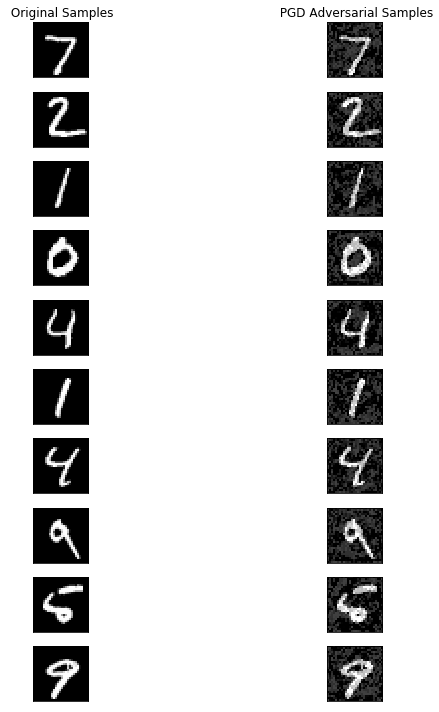

In [0]:
#Show ten original samples and their corresponding adversarial samples
#Show ten original samples and their corresponding adversarial samples
data_test_show = data_test.reshape(-1, 28, 28)
pgd_perturbations_show = pgd_perturbations.reshape(-1, 28, 28)
cols = [' Original Samples',
         ' PGD Adversarial Samples']
fig, axes = plt.subplots(nrows=10, ncols=2, figsize=(10, 10))
for i in range(10):
  axes[i, 0].imshow(data_test_show[i,:,:], 
                   cmap=plt.cm.gray)
  axes[i, 1].imshow(pgd_perturbations_show[i,:,:],
                    cmap=plt.cm.gray)
  for ax, col in zip(axes[0], cols):
    ax.set_title(col)
  for j in range(2):
    axes[i, j].get_xaxis().set_visible(False)
    axes[i, j].get_yaxis().set_visible(False)
fig.tight_layout()
plt.show()

In [0]:
adv_train_clf = keras.models.clone_model(mnist_classifier)
#modify model here if needed
adv_train_clf.build()
adv_train_clf.set_weights(mnist_classifier.get_weights())

In [0]:
pgd_data = pgd.generate_np(data_train, **pgd_params)
data_train1 = np.concatenate((data_train, pgd_data))

In [0]:
labels_train1 = np.concatenate((labels_train, labels_train))

In [0]:
print(data_train1.shape)
print(labels_train1.shape)

(120000, 784)
(120000, 10)


In [0]:
print(data_test.shape)

(10000, 784)


In [0]:
#Implementing the adversarial training defense
adv_train_clf.compile(loss="binary_crossentropy",
                      optimizer='adam',
                      metrics=['accuracy'])
adv_train_clf_hist = adv_train_clf.fit(data_train1, labels_train1,
                  validation_data=(data_test.reshape(-1, 784), labels_test),
                  epochs=50,
                  batch_size=256,
                  shuffle=True)

Train on 120000 samples, validate on 10000 samples
Epoch 1/50
120000/120000 [==============================] - 8s 69us/step - loss: 0.0206 - acc: 0.9933 - val_loss: 0.0172 - val_acc: 0.9940
Epoch 2/50
120000/120000 [==============================] - 6s 46us/step - loss: 0.0071 - acc: 0.9977 - val_loss: 0.0161 - val_acc: 0.9948
Epoch 3/50
120000/120000 [==============================] - 6s 47us/step - loss: 0.0048 - acc: 0.9985 - val_loss: 0.0138 - val_acc: 0.9954
Epoch 4/50
120000/120000 [==============================] - 6s 49us/step - loss: 0.0035 - acc: 0.9989 - val_loss: 0.0147 - val_acc: 0.9954
Epoch 5/50
120000/120000 [==============================] - 6s 51us/step - loss: 0.0026 - acc: 0.9992 - val_loss: 0.0138 - val_acc: 0.9955
Epoch 6/50
120000/120000 [==============================] - 6s 52us/step - loss: 0.0023 - acc: 0.9993 - val_loss: 0.0133 - val_acc: 0.9958
Epoch 7/50
120000/120000 [==============================] - 6s 52us/step - loss: 0.0020 - acc: 0.9993 - val_loss: 0

In [0]:
adv_train_clf.save('adversarial_trained_classifier.h5')

In [0]:
!cp adversarial_trained_classifier.h5 ./gdrive/My\ Drive/ece595_ml2/models/

In [0]:
 adv_mnist_classifier = load_model("adversarial_trained_classifier.h5")

In [0]:
print(pgd_perturbations.shape)
print(labels_test.shape)

(10000, 784)
(10000, 10)


In [0]:
#Evaluate accuracy on target classifier 
pgd_adv_scores = adv_mnist_classifier.evaluate(pgd_perturbations, labels_test)
print("Accuracy: %.2f%%"%(pgd_adv_scores[1]*100))

10000/10000 [==============================] - 1s 76us/step
Accuracy: 99.67%


In [0]:
#Using the defense to evaluate the accuracy of the perturbed data
#FILL THIS IN 

# Part 4: Carlini and Wagner Attack

In [15]:
#Implementing the CW attack

#CW Instance on trained classifier from Part 1
cwa = CarliniWagnerL2(wrap, sess=sess)

In [0]:
#Attack parameters
cwa_params = {'binary_search_steps': 1,
              'y': None,
              'learning_rate': 1.25,
              'batch_size': 16,
              'initial_const': 10,
              'clip_min': 0.0,
              'clip_max': 1.0}

In [17]:
# Generating adversarial perturbations
cwa_perturbations = cwa.generate_np(data_test, **cwa_params)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use `tf.cast` instead.

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


In [0]:
with open('cwa_perturbations.pkl', 'wb') as f:
      pickle.dump(cwa_perturbations, f)

In [0]:
!cp cwa_perturbations.pkl ./gdrive/My\ Drive/ece595_ml2/models/

In [0]:
with open(MODEL_LOCATION + 'cwa_perturbations.pkl', 'rb') as f:
      cwa_perturbations = pickle.load(f)

In [22]:
#Evaluate accuracy on target classifier 
cwa_adv_scores = mnist_classifier.evaluate(cwa_perturbations, labels_test)
print("Accuracy: %.2f%%"%(cwa_adv_scores[1]*100))

10000/10000 [==============================] - 0s 49us/step
Accuracy: 1.11%


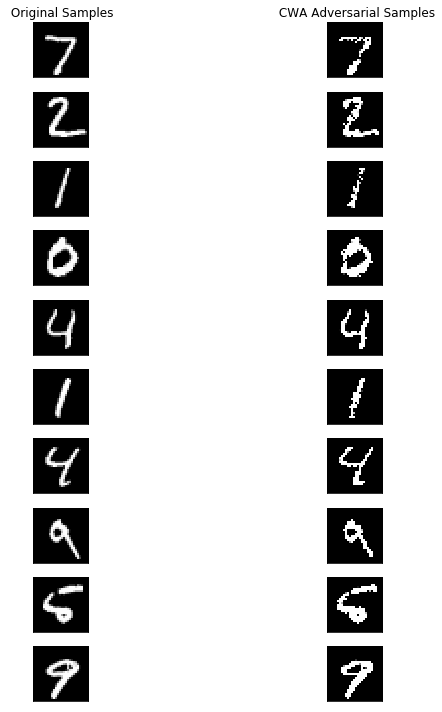

In [23]:
#Show ten original samples and their corresponding adversarial samples
data_test_show = data_test.reshape(-1, 28, 28)
cwa_perturbations_show = cwa_perturbations.reshape(-1, 28, 28)
cols = [' Original Samples',
         ' CWA Adversarial Samples']
fig, axes = plt.subplots(nrows=10, ncols=2, figsize=(10, 10))
for i in range(10):
  axes[i, 0].imshow(data_test_show[i,:,:], 
                   cmap=plt.cm.gray)
  axes[i, 1].imshow(cwa_perturbations_show[i,:,:],
                    cmap=plt.cm.gray)
  for ax, col in zip(axes[0], cols):
    ax.set_title(col)
  for j in range(2):
    axes[i, j].get_xaxis().set_visible(False)
    axes[i, j].get_yaxis().set_visible(False)
fig.tight_layout()
plt.show()

In [0]:
#Implementing the dimensionality reduction (PCA) defense 

#Calculate PCA projection
pca = PCA(100)
pca.fit(data_train)
pca_train = pca.transform(data_train)
pca_test = pca.transform(data_test)

In [25]:
print(pca_train.shape, pca_test.shape)

(60000, 100) (10000, 100)


In [0]:
#Transform perturbed CW data using the subspace from the original training data
cwa_pert_pca = pca.transform(cwa_perturbations)

In [0]:
# create model for PCA
def pca_model():
    model = Sequential()
    model.add(Dense(100,
                    activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(100,
                    activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(10,
                    activation='softmax'))

    return model

In [0]:
#Create model graph, compile it, and train it using pca_train lables_train 
model = pca_model()
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [29]:
model_hist = model.fit(pca_train, labels_train,
                       validation_data=(pca_test, labels_test),
                       shuffle=True,
                       batch_size=256,
                       epochs=50)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 38us/step - loss: 0.4592 - acc: 0.8616 - val_loss: 0.1805 - val_acc: 0.9479
Epoch 2/50
60000/60000 [==============================] - 1s 24us/step - loss: 0.1505 - acc: 0.9570 - val_loss: 0.1226 - val_acc: 0.9639
Epoch 3/50
60000/60000 [==============================] - 1s 24us/step - loss: 0.1002 - acc: 0.9712 - val_loss: 0.1012 - val_acc: 0.9692
Epoch 4/50
60000/60000 [==============================] - 1s 25us/step - loss: 0.0746 - acc: 0.9789 - val_loss: 0.0889 - val_acc: 0.9741
Epoch 5/50
60000/60000 [==============================] - 1s 25us/step - loss: 0.0591 - acc: 0.9828 - val_loss: 0.0846 - val_acc: 0.9736
Epoch 6/50
60000/60000 [==============================] - 1s 24us/step - loss: 0.0457 - acc: 0.9876 - val_loss: 0.0814 - val_acc: 0.9737
Epoch 7/50
60000/60000 [==============================] - 1s 25us/step - loss: 0.0365 - acc: 0.9896 - val_loss: 0.0745 - val_acc

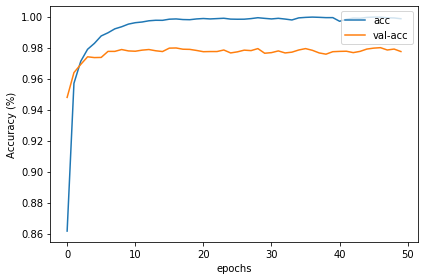

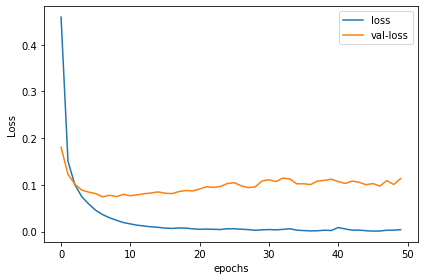

In [32]:
plot(model_hist, 'acc')
plot(model_hist, 'loss')

In [33]:
#Evaluate accuracy on target classifier 
pca_adv_scores = model.evaluate(cwa_pert_pca, labels_test)
print("Accuracy: %.2f%%"%(pca_adv_scores[1]*100))

10000/10000 [==============================] - 0s 41us/step
Accuracy: 80.82%


In [0]:
#Using the defense (and comparing to baseline accuracy)
#FILL THIS IN 
# Print the accuracy of the classifier, afterre-training it, on the perturbed data from #3 ????

# Part 5: DeepFool 

In [0]:
#Implementing the DeepFool attack

#DeepFool Instance on trained classifier from Part 1
dfa = DeepFool(wrap, sess=sess)

In [0]:
#Attack parameters
dfa_params = {'nb_candidate': 10,
              'max_iter': 50,
              'clip_min': 0.0,
              'clip_max': 1.0}

In [0]:
# Generating adversarial perturbations
dfa_perturbations = dfa.generate_np(data_test, **dfa_params)

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


In [0]:
#Evaluate accuracy of perturbed data on target classifier
dfa_adv_scores = mnist_classifier.evaluate(dfa_perturbations, labels_test)
print("Accuracy: %.2f%%"%(dfa_adv_scores[1]*100))

10000/10000 [==============================] - 1s 116us/step
Accuracy: 1.14%


In [0]:
data_test_show = data_test.reshape(-1, 28, 28)
dfa_perturbations_show = dfa_perturbations.reshape(-1, 28, 28)

In [0]:
print(data_test_show.shape)
print(dfa_perturbations_show.shape)

(10000, 28, 28)
(10000, 28, 28)


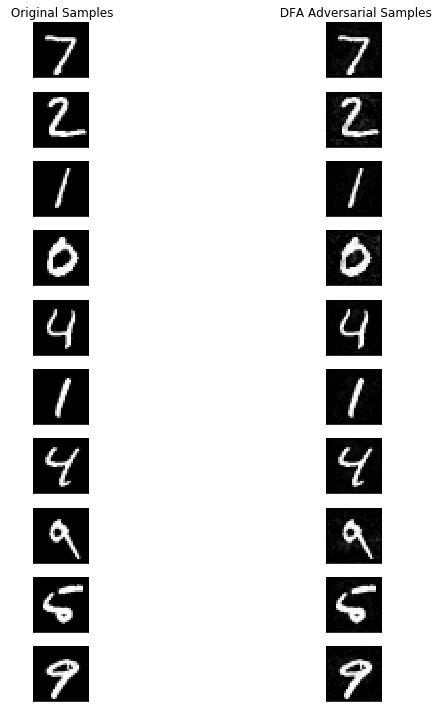

In [0]:
#Show ten original samples and their corresponding adversarial samples
cols = [' Original Samples',
        ' DFA Adversarial Samples']
fig, axes = plt.subplots(nrows=10, ncols=2, figsize=(10, 10))
for i in range(10):
  axes[i, 0].imshow(data_test_show[i,:,:], 
                   cmap=plt.cm.gray)
  axes[i, 1].imshow(dfa_perturbations_show[i,:,:],
                    cmap=plt.cm.gray)
  for ax, col in zip(axes[0], cols):
    ax.set_title(col)
  for j in range(2):
    axes[i, j].get_xaxis().set_visible(False)
    axes[i, j].get_yaxis().set_visible(False)
fig.tight_layout()
plt.show()

In [0]:
#Implementing the Denoising Autoencoder Defense

def autoencoder():
    ae = Sequential()
    ae.add(Dense(400, activation='relu', kernel_initializer="normal", input_dim=784))
    ae.add(Dense(200, activation='relu', kernel_initializer='normal'))
    ae.add(Dense(100, activation='relu', kernel_initializer='normal'))
    ae.add(Dense(200, activation='relu', kernel_initializer='normal'))
    ae.add(Dense(400, activation='relu', kernel_initializer='normal'))
    ae.add(Dense(784, activation='sigmoid', kernel_initializer='normal'))
    return ae

#Create training data for DAE 
df_attack_data_train = dfa.generate_np(data_train, **dfa_params)
data_total_train = np.concatenate([df_attack_data_train, data_train])
labels_total_train = np.concatenate([labels_train, labels_train])

In [0]:
#Create and train DAE graph
ae_model = autoencoder()
ae_model.compile(loss="categorical_crossentropy",
                 optimizer='adam',
                 metrics=['accuracy'])

In [0]:
ae_hist = ae_model.fit(data_total_train, data_total_train,
                       validation_data=(data_test, data_test),
                       shuffle=True,
                       epochs=50,
                       batch_size=256)

Train on 120000 samples, validate on 10000 samples
Epoch 1/50
120000/120000 [==============================] - 4s 37us/step - loss: 606.4622 - acc: 0.0057 - val_loss: 534.9524 - val_acc: 0.0093
Epoch 2/50
120000/120000 [==============================] - 3s 28us/step - loss: 576.1069 - acc: 0.0081 - val_loss: 526.1260 - val_acc: 0.0105
Epoch 3/50
120000/120000 [==============================] - 3s 29us/step - loss: 570.7725 - acc: 0.0099 - val_loss: 522.5440 - val_acc: 0.0128
Epoch 4/50
120000/120000 [==============================] - 3s 28us/step - loss: 568.2008 - acc: 0.0112 - val_loss: 520.8387 - val_acc: 0.0126
Epoch 5/50
120000/120000 [==============================] - 3s 28us/step - loss: 566.6137 - acc: 0.0116 - val_loss: 519.8814 - val_acc: 0.0129
Epoch 6/50
120000/120000 [==============================] - 3s 28us/step - loss: 565.4910 - acc: 0.0117 - val_loss: 518.8726 - val_acc: 0.0099
Epoch 7/50
120000/120000 [==============================] - 3s 28us/step - loss: 564.6161 -

In [0]:
#Using the defense

#Use DAE to to remove adversarial perturbation 
restorations = ae_model.predict(dfa_perturbations)

In [0]:
#Evaluate accuracy on target classifier 
dfa_adv_scores = mnist_classifier.evaluate(restorations, labels_test)
print("Accuracy: %.2f%%"%(dfa_adv_scores[1]*100))

10000/10000 [==============================] - 1s 58us/step
Accuracy: 90.81%


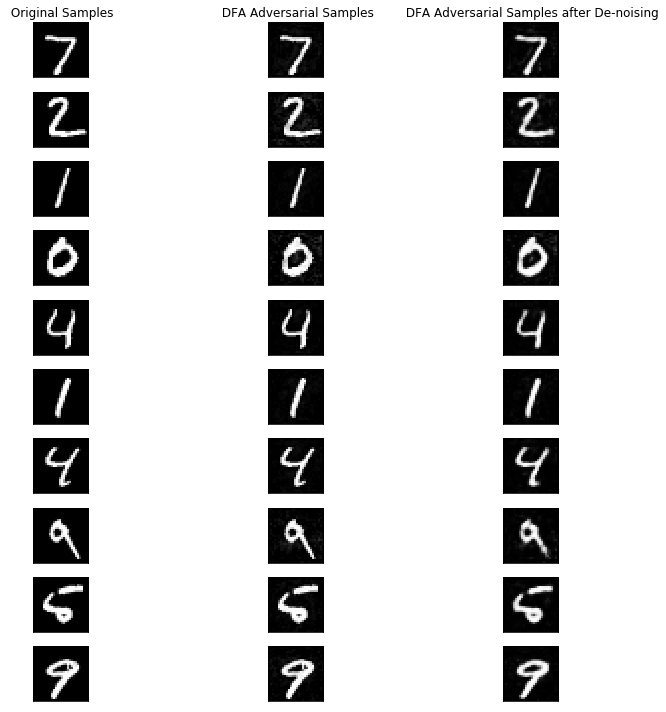

In [0]:
#Show ten samples of adversarial samples after denoising
data_test_show = data_test.reshape(-1, 28, 28)
dfa_perturbations_show = dfa_perturbations.reshape(-1, 28, 28)
restorations_show = restorations.reshape(-1, 28, 28)

cols = [' Original Samples',
        ' DFA Adversarial Samples',
        ' DFA Adversarial Samples after De-noising']
fig, axes = plt.subplots(nrows=10, ncols=3, figsize=(10, 10))
for i in range(10):
  axes[i, 0].imshow(data_test_show[i,:,:], 
                   cmap=plt.cm.gray)
  axes[i, 1].imshow(dfa_perturbations_show[i,:,:],
                    cmap=plt.cm.gray)
  axes[i, 2].imshow(restorations_show[i,:,:],
                    cmap=plt.cm.gray)
  for ax, col in zip(axes[0], cols):
    ax.set_title(col)
  for j in range(3):
    axes[i, j].get_xaxis().set_visible(False)
    axes[i, j].get_yaxis().set_visible(False)
fig.tight_layout()
plt.show()